In [285]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import corner
import math
from astropy import constants as cn
from astropy import units as u
%matplotlib inline

In [286]:
m_j = cn.M_jup.to('M_sun').value
G = cn.G.to('m3 M_sun-1 s-2').value

print(m_j)

0.0009545523100899905


In [119]:
###TEST####

#This is just a sampler, it doesn't do any fitting.

def metropolis_sampling(data, steps, proposal_variance, init):
    mu_current = [init]
    posterior = []
    
    acceptance_rate = np.zeros(int(steps))
    proposal_width = np.sqrt(proposal_variance)
    
    for s in range(int(steps)):
        #mu_guess = stats.norm(mu_current, proposal_width).rvs()
        
        mu_guess = np.random.uniform(3, 7, 1)

        prior_guess = stats.uniform(loc=mu_guess).pdf(mu_guess)
        prior_current = stats.uniform(loc=mu_guess).pdf(mu_current)

        post_guess = prior_guess
        post_current = prior_current

        accept_prob = post_guess / post_current

        r = np.random.randn()

        if accept_prob > r:
            mu_current = mu_guess
            posterior.append(mu_guess)
            acceptance_rate[s] = 1.
        else:
            mu_current = mu_current
        
    accept_rate_final = np.sum(acceptance_rate) / len(acceptance_rate)
    
    return posterior, accept_rate_final
        
###THIS IS JUST SAMPLING####

In [300]:
#Define the likelihood function as chi squared plus a residual.

def lnLikelihood(msini, P, zeropoint, t, y, yerr):
    m_star = 1.14
    model = (2 * G * np.pi)**(1/3) * (msini * m_j) / (m_star**2 * P * 24 * 3600)**(1/3) * np.sin((2*np.pi/P)*(t-zeropoint))
    #sigsq = (yerr**2 + model**2 * np.exp(2*lnf)) #borrowed from emcee
    lnlike = -0.5 * np.sum(((y-model)/yerr)**2 + np.log(yerr**2))
    return lnlike

#Define flat priors.
def lnPrior(msini, P, zeropoint):
    if not (0.5 < msini <= 1.5):
        return -np.inf
    if not (2.75 < P <= 4.5):
        return -np.inf
    if not (1512 <= zeropoint <= 1516):
        return -np.inf
    return 0.0

#Define the Metropolis Hastings algorithm.
def metropolis_fit(datax, datay, yerr, steps, proposal_variance, init):
    msini_current, p_current, zero_current = init[0], init[1], init[2] #initialize the distribution
    posterior = []
    msini_accepted = []; p_accepted = []; zero_accepted = []
    msini_rejected = []; p_rejected = []; zero_rejected = []
    
    acceptance_rate = np.zeros(int(steps)) #Keep track of the number of accepted guesses
    
    count = 0
    
    for s in range(int(steps)):
        
        #Choose a sample set of parameters.
        msini_guess, p_guess, zero_guess = np.random.multivariate_normal([msini_current, p_current, zero_current],\
                                                                         proposal_variance)
        
        #print(msini_guess, p_guess, zero_guess)
        #Calculate the posterior distribution for the proposal and current parameter sets.
        likelihood_guess = lnLikelihood(msini_guess, p_guess, zero_guess, datax, datay, yerr)
        likelihood_current = lnLikelihood(msini_current, p_current, zero_current, datax, datay, yerr)

        prior_guess = lnPrior(msini_guess, p_guess, zero_guess)
        prior_current = lnPrior(msini_current, p_current, zero_current)

        lnpost_guess = likelihood_guess + prior_guess
        lnpost_current = likelihood_current + prior_current
        
        
        #print(lnpost_guess)
        
        if math.isinf(lnpost_guess) == True:
            count += 1 #keep track of the number of times it veers outside the acceptable priors

        #The probability of acceptance is the probability that the new posterior distribution is better than the current.
        accept_prob = lnpost_guess/lnpost_current
        
        #Choose a random probability from the uniform distribution to compare the acceptance rate to.
        r = np.random.rand()
        
        #Burn in: Skip the first 1000 guesses to throw out bad parameters.
        if s < 10000:
            pass
        
        else:

            if accept_prob >= r:
                #If the new post. dist. is better, use these parameters to generate the next guess.
                msini_current, p_current, zero_current = msini_guess, p_guess, zero_guess
                
                #We don't want the minimum chi squared to be -infinity.
                if math.isinf(lnpost_guess) == False:
                    posterior.append(lnpost_guess)
                
                #Keep track of the acceptable guesses.
                msini_accepted.append(msini_guess); p_accepted.append(p_guess); zero_accepted.append(zero_guess)
            
                acceptance_rate[s] = 1.
            
            else:
                #Do not move to a new guess. Re-use the current ones.
                msini_current, p_current, zero_current = msini_current, p_current, zero_current
                msini_rejected.append(msini_guess); p_rejected.append(p_guess); zero_rejected.append(zero_guess)

        
    accept_rate_final = np.sum(acceptance_rate) / (len(acceptance_rate)-1000)
    
    params_final = np.median(msini_accepted), np.median(p_accepted), np.median(zero_accepted)
    
    params_evolution = np.array([msini_accepted, p_accepted, zero_accepted])
    
    params_rejected = np.array([msini_rejected, p_rejected, zero_rejected])
    
    print(min(posterior)) #basically minimum chi squared
    
    print(count) #number of times it stepped outside the priors
    
    return accept_rate_final, params_final, params_evolution, params_rejected

1514.8254149997138
71193.3938989
69448.7299019


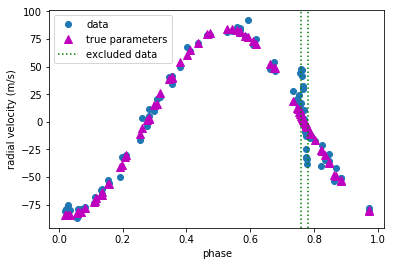

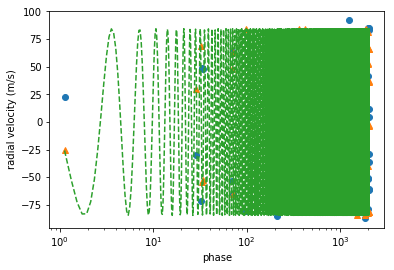

In [921]:
#Load in data
hjd, rv, rv_err = np.genfromtxt('rvcurve.txt').T

#Code was having trouble with the Julian Dates, so let's convert it to an arbitrary number of days.
hjd = (hjd/365 - 6716) * 365 #convert to years, subtract off 6000 years, go back to days
t0 = (2452854.825415/365 - 6716) * 365 #guess for the time of periastron
print(t0)

#Sanity check: Compare the values in the literature with our data.
xs = np.linspace(min(hjd), max(hjd), 10000)
model = (2 * G * np.pi)**(1/3) * (0.69 * m_j) / (1.14**2 * 3.524745 * 24 * 3600)**(1/3) *\
    np.sin((2*np.pi/3.524745)*(hjd-t0))
smodel = (2 * G * np.pi)**(1/3) * (0.69 * m_j) / (1.14**2 * 3.524745 * 24 * 3600)**(1/3) *\
    np.sin((2*np.pi/3.524745)*(xs-t0))

#Chi squared isn't great but we'll keep it.
print(np.sum((rv-model)**2/rv_err**2))

#Fold over the time series data into a phase curve.
phased = []
for d in hjd:
    phase = (d/3.5247 - int(d/3.5247))
    phased.append(phase)

plt.plot(phased, rv, 'o', label='data')
plt.plot(phased, -1*model, '^', markersize=8, color='m', label='true parameters')
#plt.plot(sphased, -1*smooth, '^c')
plt.xlabel('phase')
plt.ylabel('radial velocity (m/s)')

#There's something weird going on at a phase of ~0.77 so we'll throw out those data points.
plt.axvline(0.76, color='g', linestyle=':', label='excluded data')
plt.axvline(0.78, color='g', linestyle=':')

plt.legend()

plt.savefig('381_hw4_trueparams.jpg')

phased = np.asarray(phased)

bad = np.where((phased>=0.76)&(phased<=0.78))[0]
hjd_reduced = [element for i, element in enumerate(hjd) if i not in bad]
rv_reduced = [element for i, element in enumerate(rv) if i not in bad]
rv_err_reduced = [element for i, element in enumerate(rv_err) if i not in bad]
model_reduced = [element for i, element in enumerate(model) if i not in bad]

rv_reduced=np.asarray(rv_reduced); rv_err_reduced = np.asarray(rv_err_reduced); model_reduced = np.asarray(model_reduced)

#This improves chi squared a bit.
print(np.sum((rv_reduced-model_reduced)**2/rv_err_reduced**2))

plt.show()

plt.plot(hjd_reduced, rv_reduced, 'o')
plt.plot(hjd_reduced, model_reduced, '^')
plt.plot(xs, smodel, '--')
plt.xscale('log');
plt.xlabel('phase')
plt.ylabel('radial velocity (m/s)')

In [301]:
#We want a tiny proposal variance becasue we know the parameters pretty well.
prop_var = np.array([[10**(-6.2), 0, 0], [0, 10**(-5.5), 0], [0, 0, 10**(-6)]])
init_guess = np.array([0.75, 3.5247, 1514.8254149])

In [302]:
ar, params, evol, rej = metropolis_fit(hjd_reduced, rv_reduced, rv_err_reduced, 5e5,  prop_var, init_guess)
print(ar)

/Users/jackiebradli/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars


-61620.1770447
145035
0.644238476954


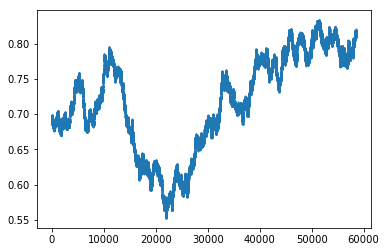

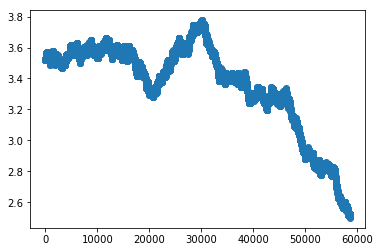

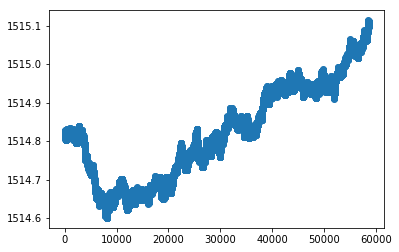

0.927521313934 3.84840404959 1514.64641219


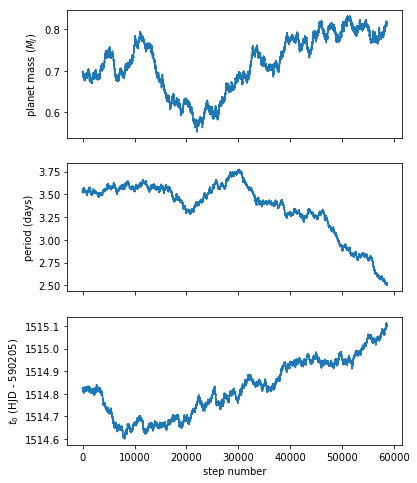

In [910]:
#Let's check out the evolution of the accepted guesses.

x = np.linspace(1, len(evol[0]), len(evol[0]))
y = np.linspace(1, len(rej[0]), len(rej[0]))

plt.plot(x, evol[0], 'o', markersize=1)
plt.show()

plt.plot(x, evol[1], 'o')
plt.show()

plt.plot(x, evol[2], 'o')
plt.show()


print(params[0], params[1], params[2])

#print(stats.mode(evol[0])[0], stats.mode(evol[1])[0], stats.mode(evol[2])[0])

f, axarr = plt.subplots(3, sharex=True, figsize=(6, 8))
axarr[0].plot(x, evol[0])
axarr[0].set_ylabel('planet mass ($M_J$)')
axarr[1].plot(x, evol[1])
axarr[1].set_ylabel('period (days)')
axarr[2].plot(x, evol[2])
axarr[2].set_ylabel('$t_0$ (HJD - 590205)')
axarr[2].set_xlabel('step number')
f.savefig('381_hw4_evol.jpg')

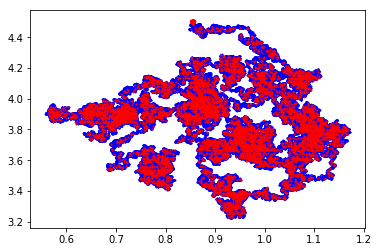

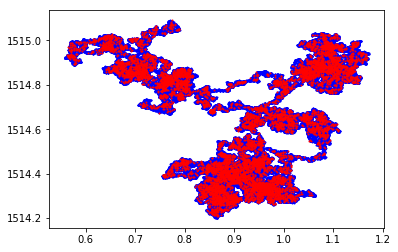

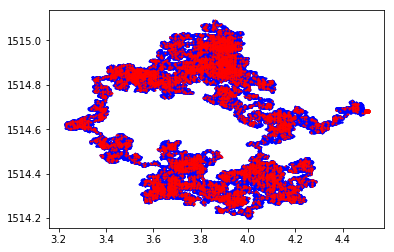

In [304]:
plt.plot(evol[0], evol[1], 'ob', markersize=1)
plt.plot(rej[0], rej[1], 'or', markersize=1)
plt.show()
plt.plot(evol[0], evol[2], 'ob', markersize=1)
plt.plot(rej[0], rej[2], 'or', markersize=1)
plt.show()
plt.plot(evol[1], evol[2], 'ob', markersize=1)
plt.plot(rej[1], rej[2], 'or', markersize=1)

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([ 0.42509808,  0.43019294,  0.43528781,  0.44038267,  0.44547754,
         0.4505724 ,  0.45566727,  0.46076213,  0.465857  ,  0.47095186,
         0.47604673,  0.48114159,  0.48623646,  0.49133132,  0.49642619,
         0.50152105,  0.50661592,  0.51171078,  0.51680565,  0.52190051,
         0.52699538,  0.53209024,  0.53718511,  0.54227997,  0.54737484,
         0.5524697 ,  0.55756457,  0.56265943,  0.5677543 ,  0.57284916,
         0.57794403,  0.58303889,  0.58813376,  0.59322862,  0.59832349,
         0.60341835,  0.60851322,  0.61360808,  0.61870295,  0.62379781,
         0.62889268,  0.63398754,  0.63908241,  0.64417727,  0.64927214,
         0.654367  ,  0.65946187,  0.66455673,  0.6696516

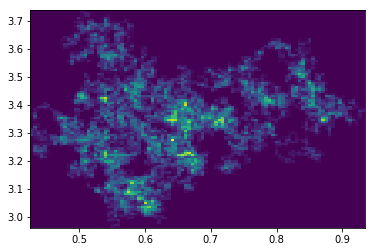

In [862]:
plt.hist2d(evol[0], evol[1], bins=100)

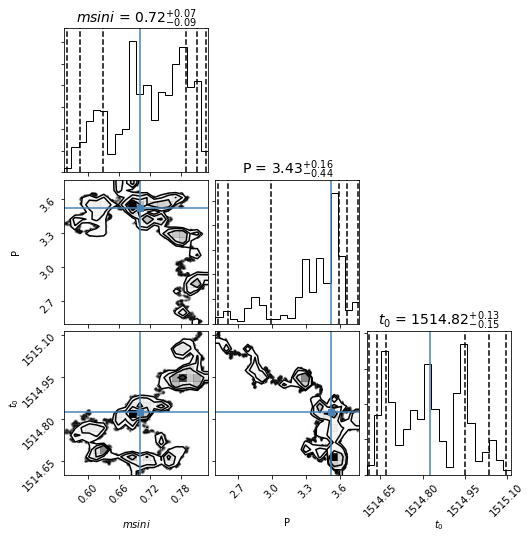

In [924]:
import corner

fig = corner.corner(evol.T, labels=["$msini$", "P", "$t_0$", r"$\Gamma \, [\mathrm{parsec}]$"],
                       quantiles=[0.001, 0.03, 0.16, 0.84, 0.95, 0.997], truths=[init_guess[0], init_guess[1], init_guess[2]], #truths_color='b',
                       show_titles=True, title_kwargs={"fontsize": 14})
fig.savefig("381_hw4corner.jpg")

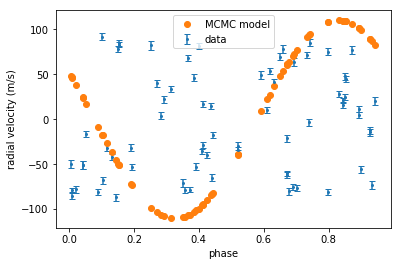

In [918]:
xs = np.linspace(min(hjd_reduced), max(hjd_reduced), 10000)

final_model = (2 * G * np.pi)**(1/3) * (params[0] * m_j) / (1.14**2 * params[1] * 24 * 3600)**(1/3) *\
    np.sin((2*np.pi/params[1])*(hjd_reduced-params[2]))
    
    
phased = []
for d in hjd_reduced:
    phase = (d/params[1] - int(d/params[1]))
    phased.append(phase)
    
model_phased = []
for d in xs:
    phase = (d/params[1] - int(d/params[1]))
    model_phased.append(phase)
    
plt.errorbar(phased, rv_reduced, yerr=rv_err_reduced, fmt='o', capsize=3, markersize=2, label='data')
plt.plot(phased, final_model, 'o', label='MCMC model')
plt.legend()
plt.xlabel('phase')
plt.ylabel('radial velocity (m/s)')

plt.savefig('381_hw4_finalmodel.jpg')

In [923]:
print(np.median(params[0]), np.median(params[1]), np.median(params[2]))

0.927521313934 3.84840404959 1514.64641219


In [876]:
np.sqrt(1e-6)

0.001